# Prepair Data

 - This notebook can be used to choose and prepare smart meter energy consumption data sets for use in the eforecaster (as an addition to the test data bundled with the forecast).
 - The notebook applies some simple checks and visualisations of data sets from different housholds to allow the user to choose a single data set for use in the eforecaster
 - The data are houshold energy consumption from the UK Power Networks Trial described here: https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
 - Go to the link above and download the `low-carbon-london-data-168-files` data set.

NOTE: The notebook can process the data into both hourly and daily data. However, eforecast currently only handles daily data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

## Prepair Data

In [2]:
def select_site(df, id):
    df_out = df[df["LCLid"]==id]
    
    return df_out

In [3]:
def process_data(df_in):
    
    df = df_in.copy()
    
    # convert to datetime
    df['DateTime'] = df['DateTime'].astype('datetime64[s]')
    df["KWH/hh (per half hour) "] = df["KWH/hh (per half hour) "].astype(np.float16) 
    
    ## HHrly and Daily resample
    df.set_index("DateTime", inplace=True)
    #remove 1970 dates
    df = df[df.index > np.datetime64('2005-02-25')]
    
    df_hhrly = df.resample('30T').sum()
    df_daily = df.resample('24H').sum()

    df_hhrly.reset_index(level=0, inplace=True)
    df_daily.reset_index(level=0, inplace=True)
    
    df_hhrly = df_hhrly.rename(columns={"DateTime": "ts", "KWH/hh (per half hour) ": "energy_kWh"})
    df_daily = df_daily.rename(columns={"DateTime": "ts", "KWH/hh (per half hour) ": "energy_kWh"})
    
    return df_hhrly, df_daily

In [4]:
def select_dates(df_in, train_start, train_end, test_start, test_end): 
    
    df = df_in.copy()
    df.set_index("ds", inplace=True)
    df_train = df[pd.to_datetime(train_start) : pd.to_datetime(train_end)]
    df_test = df[pd.to_datetime(test_start) : pd.to_datetime(test_end)]
    df_train.reset_index(level=0, inplace=True)
    df_test.reset_index(level=0, inplace=True)
    
    return df_train, df_test


In [5]:
def check_time_series_complete(ts, freq):
    """ freq: e.g 'H' or '0.5H' """
    
    print(f"Data range: from {ts.min()} to {ts.max()}")

    ts_complete = pd.date_range(ts.min(), ts.max(), freq=freq)
    
    print(f"Length of ideal ts: {ts_complete.shape[0]}, "
          f"data ts: {ts.shape[0]}")

    if sum(ts_complete != ts) == 0:
        print("Data ts and ideal ts values are the same")
    else:
        print("Data ts and ideal ts values differ")

### Obtain data from a single input file
 - each file contains multiple sites,

In [6]:
# Choose a single filename from the data set
filename = "LCL-June2015v2_0.csv"

df_all = pd.read_csv(f"../Small LCL Data/{filename}")

# check no TOU sites included - TOU sites were sites in the trial which responded to a time-of-use signal
# and hence will not represent normal energy useage
TOU_values = sum(sum([df_all["stdorToU"] != "Std"]))
print(f"{TOU_values} TOU values in the data set")

# Check for null values and replace with zero
null_values = sum(df_all["KWH/hh (per half hour) "] == "Null")
df_all["KWH/hh (per half hour) "][df_all["KWH/hh (per half hour) "] == "Null"] = 0
print(f"Replaced {null_values} Null Values with zero")

0 TOU values in the data set
Replaced 29 Null Values with zero


In [7]:
df_all.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0


### Select a site
 - Each data file includes a number of sites with unique ids. See which sites are available and then select one.

In [8]:
df_all.LCLid.unique()

array(['MAC000002', 'MAC000003', 'MAC000004', 'MAC000006', 'MAC000007',
       'MAC000008', 'MAC000009', 'MAC000010', 'MAC000011', 'MAC000012',
       'MAC000013', 'MAC000016', 'MAC000018', 'MAC000019', 'MAC000020',
       'MAC000021', 'MAC000022', 'MAC000023', 'MAC000024', 'MAC000025',
       'MAC000026', 'MAC000027', 'MAC000028', 'MAC000029', 'MAC000030',
       'MAC000032', 'MAC000033', 'MAC000034', 'MAC000035', 'MAC000036'],
      dtype=object)

In [9]:
# get site by passing one of the ids above
df1 = select_site(df_all, id="MAC000013")
#df1 = select_site(df_all, id="MAC000021")

In [10]:
# process data into cleaned hourly and daily dfs
df_hhrly, df_daily = process_data(df1)

/tmp/ipykernel_12096/1938617425.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hhrly = df.resample('30T').sum()
/tmp/ipykernel_12096/1938617425.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df.resample('24H').sum()


In [11]:
# Get some stats on the data
check_time_series_complete(df_daily.ts, freq="24H")

Data range: from 2012-06-21 00:00:00 to 2014-02-28 00:00:00
Length of ideal ts: 618, data ts: 618
Data ts and ideal ts values are the same


Text(0.5, 1.0, 'Daily Energy Use kWh')

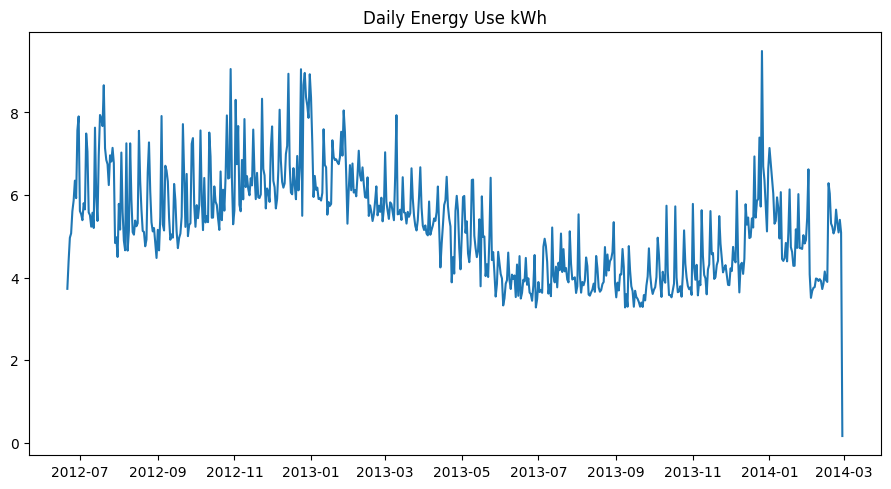

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(11, 5.5))
ax1.plot(df_daily["ts"], df_daily["energy_kWh"])
ax1.set_title("Daily Energy Use kWh")

### Save the data for use in eforecaster or investigate further
 - At this stage you may know enough to either output the data and use in the eforecaster or go back to the start and look at another site.
 - If you want to explore this data set further, continue to the next section.

In [13]:
# Ready to save the data?
#df_daily.to_csv("test_data/df_daily_test_data.csv", index=False)

### Do a Simple Linear Regression

In [14]:
# Create time dummy and Lag features

df_daily["time_dummy"] = np.arange(df_daily.shape[0])
df_daily["Lag_1"] = df_daily["energy_kWh"].shift(1)

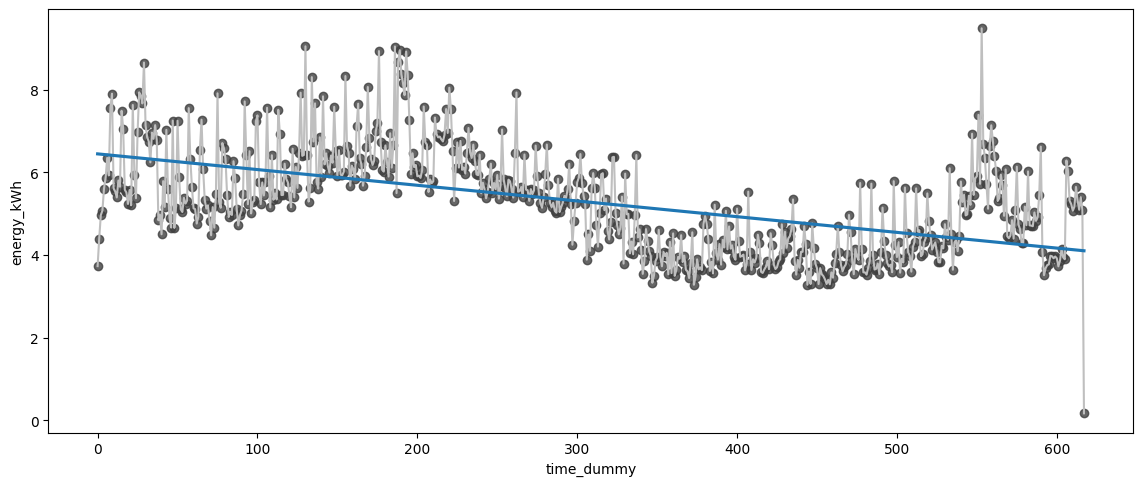

In [15]:
# Quick visualisation - Linear regression with seaborn

fig, ax = plt.subplots(figsize=(14, 5.5))
ax.plot("time_dummy", "energy_kWh", data=df_daily, color="0.75")
ax = sns.regplot(x="time_dummy", y="energy_kWh", data=df_daily, ci=None,
                scatter_kws=dict(color="0.25"))

### Trend
 - Look at monthly trend using a simple rolling window

In [16]:
# Nice way to reuse plot params
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    figsize=(18, 7)
)

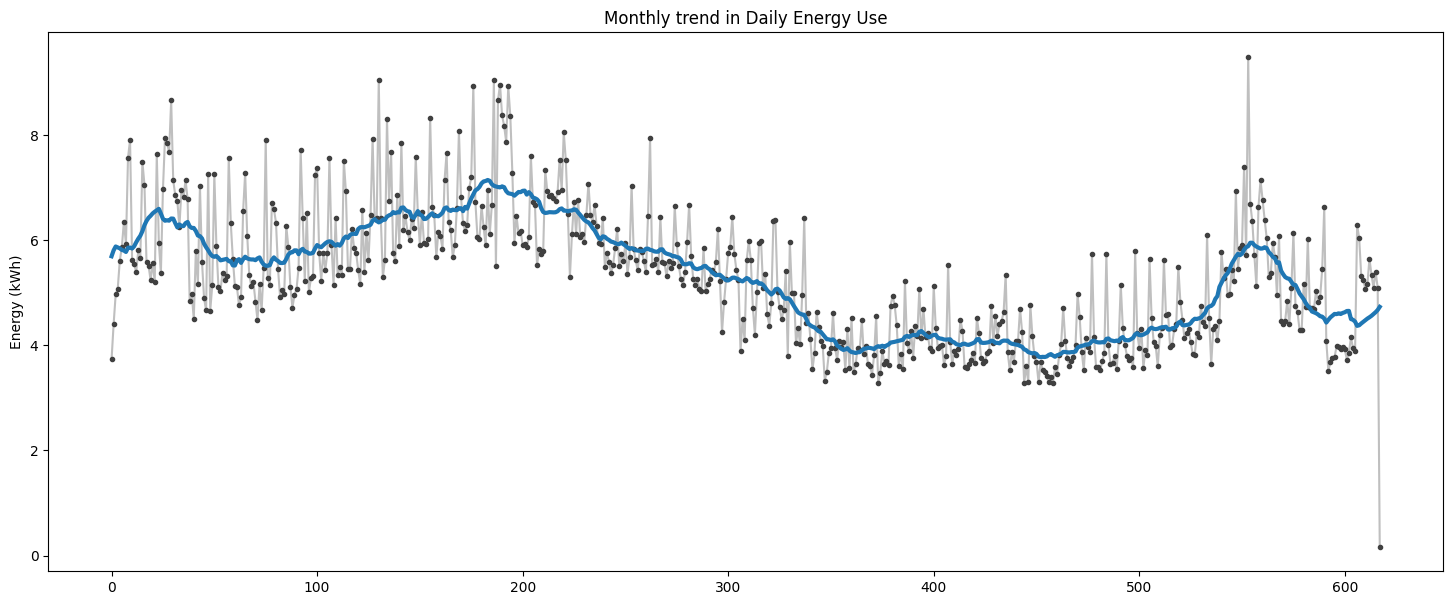

In [17]:
ax = df_daily["energy_kWh"].plot(**plot_params)

ax.set(title="Monthly trend in Daily Energy Use",
      ylabel="Energy (kWh)")

trend = df_daily["energy_kWh"].rolling(window=30,
                               center=True,
                               min_periods=3).mean()

ax = trend.plot(ax=ax, linewidth=3)